## Context 

In 2021, Maricopa County, which encompasses the Phoenix metropolitan area, was
the US county that added the most developed land since 2001 [[1](https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/)]. Urban sprawl
creates pressure on biodiversity and natural areas. In this task you will explore a
dataset showing values for a biodiversity intactness index (BII) [[2](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf), [3](https://planetarycomputer.microsoft.com/dataset/io-biodiversity)] to find changes
in this BII around the Phoenix area from 2017 to 2020.




1. Data access:
a. BII data: This dataset is part of the MPC STAC catalog. You will need to access the ‘io biodiversity’ collection and look for the 2017 and 2020 rasters covering Phoenix subdivision. You can use the following coordinates for a bounding box:
[-112.826843, 32.974108, -111.184387, 33.863574]
b. Phoenix subdivision: You will find the Phoenix subdivision polygon in
the Census County Subdivision shapefiles for Arizona:
https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&lay ergroup=County+Subdivisions

In [81]:
import numpy as np 
import geopandas as gpd
import rioxarray as rioxr 
import matplotlib.pyplot as plt 
import contextily as ctx # adding basemaps
import pandas as pd 
import matplotlib.patches as mpatches

from shapely.geometry import Polygon 


#used to access STAC catalogs# 
from pystac_client import Client 

#used to sign items from the MPC STAC catalog 
import planetary_computer

from IPython.display import Image 

In [2]:
# bll data 
# access catalog 
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace)

# coords defining bbox around phoenix subdivision 
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# search 
search = catalog.search(
    collections=["io-biodiversity"], 
    bbox=bbox, 
    datetime=['2017','2020']
)

# get items from search
items = search.item_collection()
print(f'There are {len(items)} items in the search.')

There are 4 items in the search.


In [3]:
#To get the items found in the search (or check if there were any matches in the search) we use the item_collection() method:
#This output tells us there were two items in the catalog that matched our search!

items

id: bii_2020_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


In [4]:
# Item 2017
#Let’s get the first item in the search:

# get first item in the catalog search (year 2017) 
item2017 = items[0]
type(item2017)

#items[0].properties

item2017.properties
#asset = items.assets['data']


for key in item2017.assets.keys():
    print(key, '--', item2017.assets[key].title)
    

# plot rendered preview
Image(url=item2017.assets['rendered_preview'].href, width=500)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [5]:
# Item 2020
#Let’s get the first item in the search:

# get first item in the catalog search (year 2020) 
item2020 = items[3]
type(item2020)

#items[0].properties

item2020.properties
#asset = items.assets['data']


for key in item2020.assets.keys():
    print(key, '--', item2020.assets[key].title)
    

# plot rendered preview
Image(url=item2020.assets['data'].href, width=500)


data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


<Axes: >

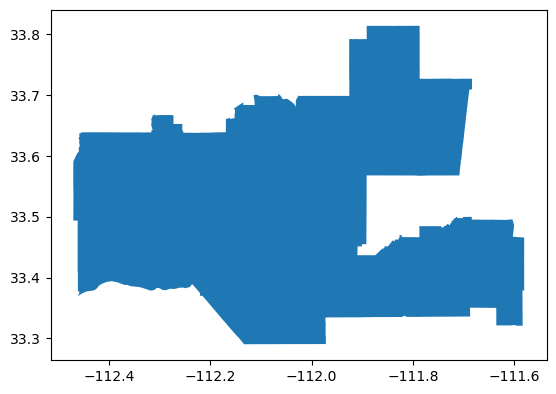

In [6]:
arizona = gpd.read_file("~/biodiv-index-phx/data/tl_2022_04_cousub.shp")
phoenix = arizona[arizona['NAME']== "Phoenix"]

phoenix.plot()

Create a map showing the Phoenix subdivision within an appropriate geographical context. You may use any vector datasets to create your map. (You can also check out the contextily package.)

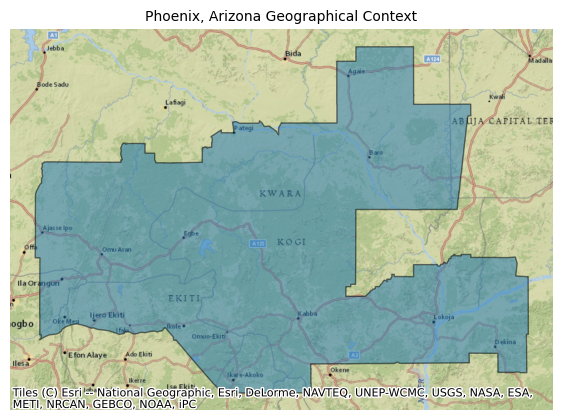

In [7]:
# create axis with plot
ax = (phoenix.to_crs(epsg=2223)
      .plot(figsize=(7, 7), alpha=0.5, edgecolor="k")
      )

# add NatGeo basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Phoenix, Arizona Geographical Context", fontdict={"fontsize": "10"})

ax.set_axis_off()

3. Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020.
HINTS (useful or not depending on your workflow):


- Let x be an xarray.DataArray. We can select all the values greater than n by simply doing x>n. This will return an xarray.DataArray with boolean values. You can then transform this into an xarray.DataArray with 0s and 1s (instead of True/False) by casting it as type ‘int’.


- To calculate the percentage area: (pixels in class)/(total pixels) * 100.

EPSG:4326 4326 4326


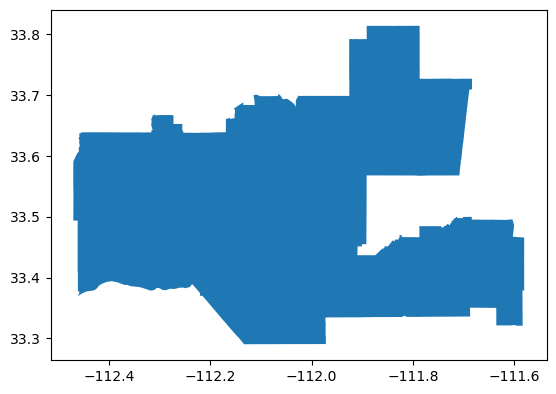

In [8]:
#next, we need to standardize the raster / crs to be the same one. I've chosen to transform the shapefile crs. 

#check crs of shape file and raster 
#crs of the raster: EPSG 4326
item2017.properties['proj:epsg']
item2020.properties['proj:epsg']


#crs of the shapefile: EPSG 4269
phoenix.plot()

#convert crs of phoenix shapefile to raster 
phoenix = phoenix.to_crs(epsg = 4326)

#check cr's; they're all the same now. 
print(phoenix.crs, item2017.properties['proj:epsg'], item2020.properties['proj:epsg'])



In [9]:
#convert them into xarray.DataArray.... maybe we do this after we have clipped 

item2017_df = rioxr.open_rasterio(item2017.assets['data'].href)

item2020_df = rioxr.open_rasterio(item2020.assets['data'].href)


In [10]:
#Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020.

#- We can select all the values greater than n in the xarray.DataArray by simply doing x>n. 
#This will return an xarray.DataArray with boolean values. 
#You can then transform this into an xarray.DataArray with 0s and 1s (instead of True/False) by casting it as type ‘int’.


#create a mask / clip 
phx_2017 = item2017_df.rio.clip(phoenix.geometry)
phx_2020 = item2020_df.rio.clip(phoenix.geometry)


#check plot 
#phx_2017.plot()
#phx_2020.plot()

##check data types to confirm they're now the desired data types
print(type(phx_2017) , type(phx_2020))


##selecting area.... substitute item2017_df with the phoenix portions of those data 
select_2017 = 1*(phx_2017 >= 0.75)
select_2020 = 1*(phx_2020 >= 0.75)


#now, maybe

#- To calculate the percentage area: (pixels in class)/(total pixels) * 100.

px_total_17 = np.unique(select_2017, return_counts=True)
px_total_20 = np.unique(select_2020, return_counts=True)

<class 'xarray.core.dataarray.DataArray'> <class 'xarray.core.dataarray.DataArray'>


In [11]:
px_counts_17 = np.unique(px_total_17, return_counts=True)


# initialize dictionary with columns' data 
pix_counts_total17 = {'BII' : px_total_17[0],
     'number_pixs' : px_total_17[1]
     }

# create data frame
pix_counts_total_17df = pd.DataFrame(pix_counts_total17)

In [12]:
total_pixels_17 = (sum(pix_counts_total_17df.number_pixs) - pix_counts_total_17df.number_pixs[pix_counts_total_17df.index.max()])/sum(pix_counts_total_17df.number_pixs)
total_pixels_17


0.961907237035882

In [13]:
px_counts_20 = np.unique(px_total_20, return_counts=True)


# initialize dictionary with columns' data 
pix_counts_total20 = {'BII' : px_total_20[0],
     'number_pixs' : px_total_20[1]
     }

# create data frame
pix_counts_total_20df = pd.DataFrame(pix_counts_total20)

In [14]:
total_pixels_20 = (sum(pix_counts_total_20df.number_pixs) - pix_counts_total_20df.number_pixs[pix_counts_total_20df.index.max()])/sum(pix_counts_total_20df.number_pixs)

total_pixels_20

0.9581873624755272

4. Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020. Here’s an example:

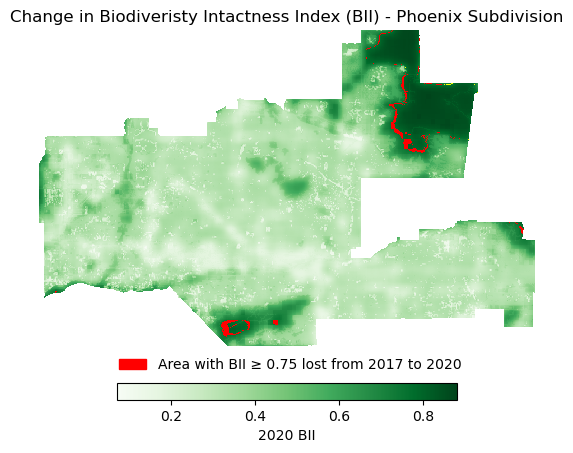

In [140]:
R3 = select_2017-select_2020

R3 = R3.squeeze().drop('band')

type(R3)
R3 = R3.where(R3 != 0, np.nan)



# Create a new figure
fig, ax = plt.subplots()

# Plot the first raster with its colorbar
im1 = phx_2020.plot(ax=ax, cmap='Greens', add_colorbar=False)
cbar1 = plt.colorbar(im1, ax=ax, orientation='horizontal', fraction=0.046, pad=0.1)
cbar1.set_label('2020 BII')

    
# Rotate the colorbar label for the first raster
cbar1.ax.yaxis.label.set_rotation(270)  # Adjust the rotation angle as needed


# Plot the second raster without its colorbar
im2 = R3.plot(ax=ax, cmap="autumn", add_colorbar=False)
#setting the patch for difference raster 
R3_patches = mpatches.Patch(color='Red', label = "Area with BII ≥ 0.75 lost from 2017 to 2020") 

handles, labels = ax.get_legend_handles_labels() 
ax.legend(handles = [R3_patches], frameon= False, loc = (0.15,-0.1))


ax.axis('off')
ax.set_title('Change in Biodiveristy Intactness Index (BII) - Phoenix Subdivision')



# Show the plot
plt.show()